In [13]:
%matplotlib widget


In [2]:
from i_o import Paths
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os, glob, h5py
import importlib, pathlib
from daio.h5 import lazyh5
from IPython.display import JSON
import pandas as pd

In [77]:
pn_psfs = r"~/hpc-rw/lfm/psfs"
pn_rec = r"~/hpc-r/lfm2025/recordings"
pn_bg = r"~/hpc-rw/lfm/bg"
url_home = r"/home/lubo12/"
pn_out = r"~/hpc-rw/lfm/results"

dataset_name = "20250701_1538_LB_ZF_v552_f5_40fps_1"
psf_name = "20250701_1216_PSF_LB_noap_1"
bg_name = "20250701_1651_LB_bg_40fps.npy"
# bg_name = "20250701_1649_LB_bg_80fps.npy"

import i_o
importlib.reload(i_o)
from i_o import Paths

paths = Paths(dataset_name=dataset_name,
              psf_name = psf_name,
              bg_name=bg_name,
              pn_bg= pn_bg,
              pn_rec = pn_rec,
              pn_psfs=pn_psfs,
              pn_out=pn_out,
              url_home=url_home,
              )

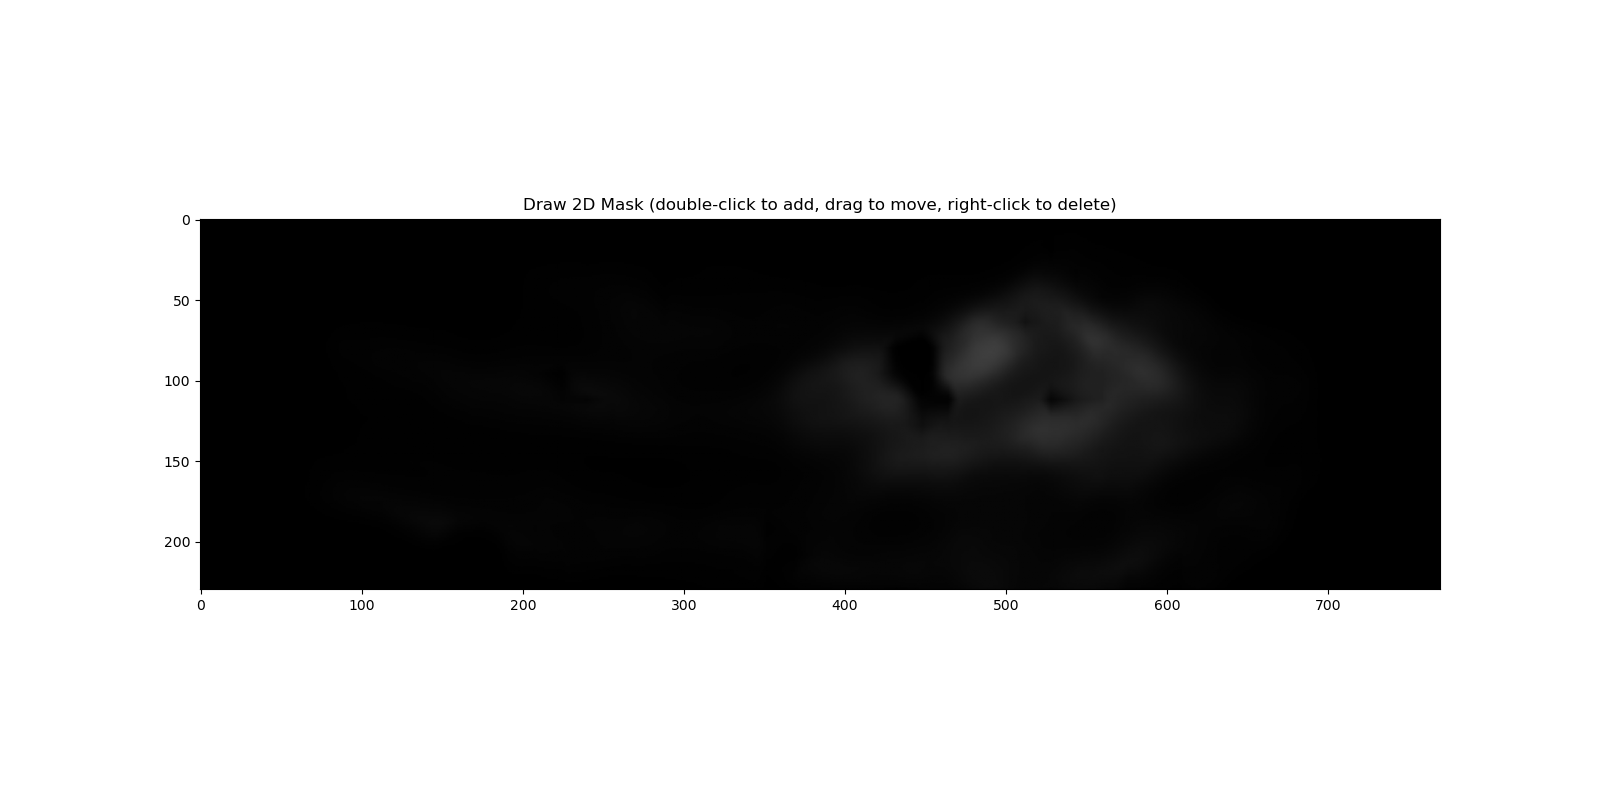

In [31]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
from skimage.draw import polygon as skpolygon
from ipywidgets import IntSlider, VBox, Button

# ---- User settings ----
vmin = 0  # Set to None for auto, or a number for manual
vmax = 7  # Set to None for auto, or a number for manual
figsize = (16, 8)
mask_every = 5  # Draw mask every nth slice
# -----------------------

volume = np.load("test_ref_vol.npy").transpose(0,2,1)
nz, ny, nx = volume.shape

if vmin is None:
    vmin = float(np.min(volume))
if vmax is None:
    vmax = float(np.max(volume))

fig, ax_orig = plt.subplots(1, 1, figsize=figsize)
maskable_slices = list(range(0, nz, mask_every))
current_idx = 0
current_z = maskable_slices[current_idx]
im_orig = ax_orig.imshow(volume[current_z], cmap='gray', vmin=vmin, vmax=vmax)
ax_orig.set_title("Draw 2D Mask (double-click to add, drag to move, right-click to delete)")

# Store 2D polygons for every nth slice: {z: [(y, x), ...]}
if 'masks_2d' not in locals() or not isinstance(masks_2d, dict):
    masks_2d = {}
points_2d = []  # Current slice points [(y, x), ...]
point_artists = []
polygon_artist = None
dragging_idx = None
last_event_was_double = False

def redraw():
    global polygon_artist
    for artist in point_artists:
        artist.remove()
    point_artists.clear()
    if polygon_artist is not None:
        polygon_artist.remove()
        polygon_artist = None
    for y, x in points_2d:
        artist, = ax_orig.plot(x, y, 'ro', picker=5)
        point_artists.append(artist)
    if len(points_2d) > 2:
        poly = np.array(points_2d)
        # Draw with (x, y) order for matplotlib
        polygon_artist = plt.Polygon(np.column_stack([poly[:,1], poly[:,0]]), closed=True, fill=False, edgecolor='lime', linewidth=2)
        ax_orig.add_patch(polygon_artist)
    im_orig.set_data(volume[current_z])
    fig.canvas.draw_idle()

def get_closest_point(y, x, threshold=10):
    if not points_2d:
        return None
    arr = np.array(points_2d)
    dists = np.hypot(arr[:,0] - y, arr[:,1] - x)
    idx = np.argmin(dists)
    if dists[idx] < threshold:
        return idx
    return None

def on_press(event):
    global dragging_idx, last_event_was_double
    if event.inaxes != ax_orig:
        return
    x, y = event.xdata, event.ydata
    if event.button == 1:
        if last_event_was_double:
            last_event_was_double = False
            return
        idx = get_closest_point(y, x)
        if idx is not None:
            dragging_idx = idx
    elif event.button == 3:
        idx = get_closest_point(y, x)
        if idx is not None:
            points_2d.pop(idx)
            redraw()

def on_release(event):
    global dragging_idx
    dragging_idx = None

def on_motion(event):
    if dragging_idx is None or event.inaxes != ax_orig:
        return
    x, y = event.xdata, event.ydata
    points_2d[dragging_idx] = (y, x)
    redraw()

def on_double_click(event):
    global last_event_was_double
    if event.inaxes != ax_orig or event.button != 1:
        return
    x, y = event.xdata, event.ydata
    points_2d.append((y, x))
    last_event_was_double = True
    redraw()

def on_slice_change(change):
    global current_idx, current_z, points_2d
    # Save current points
    masks_2d[current_z] = points_2d.copy()
    # Change slice
    current_idx = change['new']
    current_z = maskable_slices[current_idx]
    points_2d[:] = masks_2d.get(current_z, []).copy()
    redraw()

fig.canvas.mpl_connect('button_press_event', on_press)
fig.canvas.mpl_connect('button_release_event', on_release)
fig.canvas.mpl_connect('motion_notify_event', on_motion)
fig.canvas.mpl_connect('button_press_event', lambda e: on_double_click(e) if e.dblclick else None)

slider = IntSlider(value=0, min=0, max=len(maskable_slices)-1, step=1, description='z (mask)')
slider.observe(on_slice_change, names='value')

# Initialize first slice
points_2d = masks_2d.get(current_z, []).copy()
redraw()

VBox([slider, fig.canvas])

In [73]:
import numpy as np
from skimage.draw import polygon as skpolygon
from scipy.ndimage import distance_transform_edt

mask_3d = np.zeros_like(volume, dtype=bool)
mask_slices = sorted([z for z in masks_2d if len(masks_2d[z]) > 0])
if mask_slices:
    # Create binary masks for each annotated slice
    binary_masks = {}
    for z in mask_slices:
        pts = masks_2d[z]
        mask = np.zeros((ny, nx), dtype=bool)
        if len(pts) == 1:
            y, x = np.round(pts[0]).astype(int)
            if 0 <= y < ny and 0 <= x < nx:
                mask[y, x] = True
        elif len(pts) > 2:
            poly = np.array(pts)
            rr, cc = skpolygon(poly[:,0], poly[:,1], (ny, nx))
            mask[rr, cc] = True
        binary_masks[z] = mask

    # Compute signed distance transforms for each mask
    dt = {}
    for z in mask_slices:
        mask = binary_masks[z]
        dt[z] = distance_transform_edt(mask) - distance_transform_edt(~mask)

    # Interpolate distance transforms for all slices
    dt_stack = np.zeros((nz, ny, nx), dtype=np.float32)
    for z in range(nz):
        # Find the two nearest annotated slices
        if z <= mask_slices[0]:
            dt_stack[z] = dt[mask_slices[0]]
        elif z >= mask_slices[-1]:
            dt_stack[z] = dt[mask_slices[-1]]
        else:
            # Find z0 < z < z1
            for i in range(len(mask_slices)-1):
                z0, z1 = mask_slices[i], mask_slices[i+1]
                if z0 <= z <= z1:
                    alpha = (z - z0) / (z1 - z0) if z1 != z0 else 0
                    dt_stack[z] = (1-alpha)*dt[z0] + alpha*dt[z1]
                    break
    # Threshold to get the mask
    mask_3d = dt_stack > 0

mask

vol = np.load("test_ref_vol.npy").transpose(0,2,1)
vol *= mask_3d
vol = get_clipped_array(vol, vmin = 0, vmax=5, absolute_limits=True).get()
OrthoViewsWidget(vol)

OrthoViewsWidget(coords=[72, 112, 384], sar=[1.0, 1.0, 1.0], src=['data:video/mp4;base64,AAAAIGZ0eXBpc29tAAACA…

In [79]:
with h5py.File(paths.reg_mask, "w") as f:
    f.create_dataset("mask_3d", data=mask_3d)
    g = f.create_group("masks_2d")
    for k, v in masks_2d.items():
        arr = np.array(v, dtype=np.float32).reshape(-1, 2)  # shape (N, 2) or (0, 2)
        g.create_dataset(str(k), data=arr)
    f.attrs["mask_every"] = 5

In [9]:
import numpy as np
from video import get_clipped_array
from opm_img.orthoviews import OrthoViewsWidget



volume = np.load("test_ref_vol.npy").transpose(0,2,1)
volume = get_clipped_array(volume, vmin = 0, vmax=5, absolute_limits=True).get()
OrthoViewsWidget(volume)


OrthoViewsWidget(coords=[72, 112, 384], sar=[1.0, 1.0, 1.0], src=['data:video/mp4;base64,AAAAIGZ0eXBpc29tAAACA…

In [82]:
import widgets
importlib.reload(widgets)
from widgets import get_mask_widget, ortho_views_widget

get_mask_widget(volume, paths.reg_mask, vmin=0, vmax=7, figsize=(16,5), mask_every=5, sigma=2.0)

In [46]:

OrthoViewsWidget(

<IPython.core.display.JSON object>

In [69]:
import h5py
with h5py.File("test.h5", "r") as f:
    for k, v in f["masks_2d"].items():
        arr =  np.array(v)
        print(int(k),arr)
        if arr.size==0:
            print("empty")
    test = np.array(f["masks_2d"]["65"])
test

0 b'[]'
10 b'[]'
100 b'[(151.77746975806454, 500.62096774193554)]'
115 b'[]'
120 b'[]'
125 b'[]'
135 b'[]'
140 b'[]'
15 b'[]'
150 b'[]'
20 b'[]'
25 b'[]'
30 b'[]'
35 b'[]'
40 b'[]'
5 b'[]'
50 b'[]'
55 b'[(144.32585685483872, 503.72580645161287)]'
60 b'[]'
65 b'[(91.54359879032262, 468.9516129032258), (106.4468245967742, 423.62096774193554), (131.90650201612905, 377.0483870967742), (210.7694052419355, 432.93548387096774), (171.0274697580645, 554.0241935483871)]'
70 b'[]'
75 b'[]'
80 b'[]'
90 b'[(101.47908266129036, 470.19354838709677), (188.41456653225808, 404.99193548387103), (142.46295362903228, 575.1370967741937)]'
95 b'[]'


array(b'[(91.54359879032262, 468.9516129032258), (106.4468245967742, 423.62096774193554), (131.90650201612905, 377.0483870967742), (210.7694052419355, 432.93548387096774), (171.0274697580645, 554.0241935483871)]',
      dtype=object)

In [68]:
from IPython.display import Video, display

display(Video(filename, embed=True, width=600, html_attributes="controls loop"))


array(b'[(91.54359879032262, 468.9516129032258), (106.4468245967742, 423.62096774193554), (131.90650201612905, 377.0483870967742), (210.7694052419355, 432.93548387096774), (171.0274697580645, 554.0241935483871)]',
      dtype=object)